# Objective

Investigate precision and recall for the 50 spots which are common in each image in the persistence experiment.

Precision = 1 - FPR = 1 - (number of incorrect centroids / number of centroids)

As an estimate for the number of resulting centroids that are actually associated with the 50 spots which are common in each image, I am using number of centroids = 50.

Recall = TPR = number of detected spots / number of spots

# Takeaways

**Note:** Given the way that I calculated precision, sometimes precision is greater than 1 because there are more than fifty spots centroids close to the 50 spots which are common in each image.

All data points on the ROC curve at the bottom of this notebook are within a small region, so it's hard to gauge any patterns, though precision seems to increase as the number of spots increases. (Perhaps when a worker sees a greater spot density, each click is more likely to be close to a spot.)  For easier visualization, I split the ROC curve into one plot for precision and one for recall. Precision and recall both drop precipitously between 200 and 225 spots (if one can consider 1.00, 1.00 -> 0.92, 0.96 to be a precipitous).

In [1]:
import os, sys, math
sys.path.insert(0, '../../FISH-annotation/Annotation')
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from QuantiusAnnotation import QuantiusAnnotation
import util
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

In [2]:
num_spots_list = np.arange(50, 250, 25)
cwd = os.getcwd()

In [3]:
TPR_list, FPR_list, num_annotators_list = [], [], []
csv_filepath = cwd + '/spot_data/snr_10_numspots_50_coord_snr_list.csv'

for num_spots in num_spots_list:
    json_filepath = cwd+ '/annotations/' + 'snr10_' + str(num_spots) + '.json'
    img_filename = 'snr_10_numspots_' + str(num_spots) + '_spot_img.png'
    img_filepath = cwd + '/spot_images/' + img_filename
    qa = QuantiusAnnotation(json_filepath, img_filename)
    sa = SpotAnnotationAnalysis(qa)
    anno_all = qa.df()

    clustering_params = ['AffinityPropagation', -350]
    clusters = sa.get_clusters(anno_all, clustering_params)

    img_height = anno_all['height'].values[0]

    """ Screen by Cluster Size """
    cluster_size_threshold = util.get_cluster_size_threshold(clusters)
    small_clusters, large_clusters = util.sort_clusters_by_size(clusters, cluster_size_threshold)

    """ Detect Clumps """
    clumpiness_threshold = util.get_clumpiness_threshold(large_clusters)
    clumpy_clusters, nonclumpy_clusters = util.sort_clusters_by_clumpiness(large_clusters, clumpiness_threshold)

    """ Declump """
    declumping_params = ['KMeans', 2]
    result_clusters = nonclumpy_clusters
    for i in range(len(clumpy_clusters.index)):
        subclusters = util.declump(clumpy_clusters, i, declumping_params)
        result_clusters = pd.concat([subclusters, result_clusters], ignore_index=True)

    
    result_points = result_clusters.loc[:, ['centroid_x', 'centroid_y']].as_matrix()
    result_kdt = KDTree(result_points, leaf_size=2, metric='euclidean')
    
    ref_df = pd.read_csv(csv_filepath)
    ref_points = ref_df.loc[:, ['col', 'row']].as_matrix().tolist()
    ref_kdt = KDTree(ref_points, leaf_size=2, metric='euclidean')

    """ TPR """
    detected_spots = 0
    for point in ref_points:
        dist, ind = result_kdt.query([[point[0], img_height-point[1]]], k=1)
        if dist[0][0] <= 4:
            detected_spots += 1
    tpr = float(detected_spots) / 50
    TPR_list.append(tpr)
    
    """ FPR """
    correct_centroids = 0
    for point in result_points:
        dist, ind = ref_kdt.query([[point[0], img_height-point[1]]], k=1)
        if dist[0][0] <= 4:
            correct_centroids += 1
    
    fpr = 1 - float(correct_centroids) / 50
    FPR_list.append(fpr)


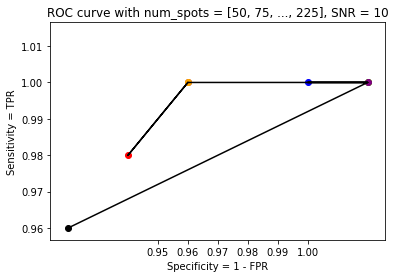

num spots
[ 50  75 100 125 150 175 200 225]
TPR
[1.0, 0.98, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96]
FPR
[0.04, 0.06, 0.04, -0.02, -0.02, 0.0, -0.02, 0.08]
[1.0, 0.98, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96]


In [15]:
sensitivity = TPR_list
specificity = [1 - fpr for fpr in FPR_list]

import matplotlib.pyplot as plt
colors = ('brown','red','orange','yellow','green','blue','purple','black')
for spec, sen, col in zip(specificity, sensitivity, colors):
    plt.scatter(spec, sen, c=col)
plt.plot(specificity, sensitivity, color='black')
plt.title('ROC curve with num_spots = [50, 75, ..., 225], SNR = 10')
plt.xlabel('Specificity = 1 - FPR')
plt.ylabel('Sensitivity = TPR')
# plt.xlim(0.95, 1.005)
plt.xticks(np.arange(0.95, 1.005, 0.01))
plt.show()
print('num spots')
print(num_spots_list)
print('TPR')
print ([round(i, 2) for i in TPR_list])
print('FPR')
print ([round(i, 2) for i in FPR_list])

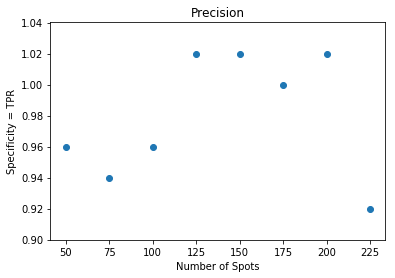

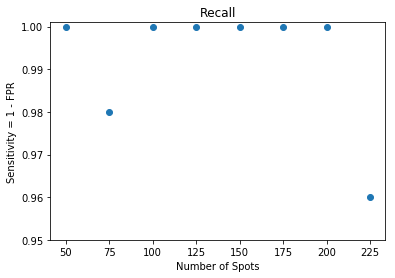

In [25]:
plt.scatter(num_spots_list, specificity)
plt.title('Precision')
plt.xlabel('Number of Spots')
plt.ylabel('Specificity = TPR')
plt.show()
plt.scatter(num_spots_list, sensitivity)
plt.title('Recall')
plt.xlabel('Number of Spots')
plt.ylabel('Sensitivity = 1 - FPR')
plt.ylim(0.95, 1.001)
plt.yticks(np.arange(0.95, 1.009, 0.01))
plt.show()